In [87]:
KAGGLE=False
TRAIN_MODEL=False
TRAIN_DISTIL=False
BUILD_ONNX=False

In [62]:
from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import onnxruntime
import onnxruntime.quantization
import optuna
import os
from pathlib import Path
import psutil
from scipy.special import softmax
import sys
from time import perf_counter
import torch
from torch import quantize_per_tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.quantized import QFunctional
from torch.quantization import quantize_dynamic
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments, pipeline
import transformers.convert_graph_to_onnx

In [4]:
if KAGGLE:
    import subprocess
    
    print(subprocess.check_output(['pip', 'install', 'optuna', 'https://github.com/olpa/var_exchange/archive/refs/tags/1.0.0.zip']))
    print(subprocess.check_output(['apt-get', 'install', 'git-lfs']))
    print(subprocess.check_output(['git', 'lfs', 'install']))

In [5]:
if KAGGLE:
    from huggingface_hub import notebook_login
    
    notebook_login()

In [6]:
from var_exchange.kaggle_dropbox import get_putv_getv

putv, getv = get_putv_getv(basedir='ch08_production')

# p210 Intent Detection as a Case Study

In [7]:
bert_ckpt = 'transformersbook/bert-base-uncased-finetuned-clinc'
pipe = pipeline('text-classification', model=bert_ckpt)

In [8]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

# p212 Creating a Performance Benchmark

In [9]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type='BERT baseline'):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
    
    def compute_accuracy(self):
        # We'll define this later
        pass
    
    def compute_size(self):
        # We'll define this later
        pass
    
    def time_pipeline(slef):
        # We'll define this later
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics
    
    def print_performance_metrics(self, metrics):
        metrics = metrics[self.optim_type]
        print(f"Accuracy on test set - {metrics['accuracy']:.3f}")
        print(f"Model size (MB) - {metrics['size_mb']:.2f}")
        print(f"Average latency (ms) - {metrics['time_avg_ms']:.2f} +/- {metrics['time_std_ms']:.2f}")

In [10]:
clinc = load_dataset('clinc_oos', 'plus')

Reusing dataset clinc_oos (/home/olpa/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
sample = clinc['test'][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [12]:
intents = clinc['test'].features['intent']
intents.int2str(sample['intent'])

'transfer'

In [13]:
accuracy_score = load_metric('accuracy')

def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example['text'])[0]['label']
        label = example['intent']
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    return accuracy
    
PerformanceBenchmark.compute_accuracy = compute_accuracy

In [14]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [15]:
def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path('model.pt')
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    return {'size_mb': size_mb}

PerformanceBenchmark.compute_size = compute_size

In [16]:
for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f'Latency (ms) - {1000 * latency:.3f}')

Latency (ms) - 68.918
Latency (ms) - 39.705
Latency (ms) - 34.110


In [17]:
def time_pipeline(self, query='What is the pin number for my account?'):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    return {'time_avg_ms': time_avg_ms, 'time_std_ms': time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [18]:
pb = PerformanceBenchmark(pipe, clinc['test'])

base_metrics = getv('base_metrics')
if not base_metrics:
    base_metrics = pb.run_benchmark()
    putv(base_metrics, 'base_metrics')

pb.print_performance_metrics(base_metrics)
perf_metrics = base_metrics

Accuracy on test set - 0.856
Model size (MB) - 255.89
Average latency (ms) - 63.49 +/- 47.91


# p217 Knowledge Distillation for Fine-Tuning

In [19]:
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [20]:
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction='batchmean')
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

In [21]:
student_ckpt = 'distilbert-base-uncased'
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch['text'], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=['text'])
clinc_enc = clinc_enc.rename_column('intent', 'labels')

Loading cached processed dataset at /home/olpa/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-92136311ab2193fa.arrow
Loading cached processed dataset at /home/olpa/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-989b7628a9114f95.arrow
Loading cached processed dataset at /home/olpa/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-47380080633de551.arrow


In [22]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    # breakpoint()  # FIXME
    return accuracy_score.compute(predictions=predictions, references=labels)

In [23]:
batch_size = 48

finetuned_ckpt = 'distilbert-base-uncased-finetuned-clinc'
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = 'epoch',
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=True
)

In [24]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [25]:
num_labels = intents.num_classes
student_config = (AutoConfig
                 .from_pretrained(student_ckpt, num_labels=num_labels,
                                 id2label=id2label, label2id=label2id))

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def student_init():
    return (AutoModelForSequenceClassification
           .from_pretrained(student_ckpt, config=student_config).to(device))

In [27]:
teacher_ckpt = 'transformersbook/bert-base-uncased-finetuned-clinc'
teacher_model = (AutoModelForSequenceClassification
                .from_pretrained(teacher_ckpt, num_labels=num_labels)
                .to(device))

distilbert_trainer = DistillationTrainer(
    teacher_model=teacher_model,
    model_init=student_init,
    args=student_training_args,
    train_dataset=clinc_enc['train'],  # FIXME
    # train_dataset=clinc_enc['train'].select(range(5)),  # FIXME
    eval_dataset=clinc_enc['validation'],  # FIXME
    # eval_dataset=clinc_enc['validation'].select(range(5)),  # FIXME
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/olpa/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Bert

In [28]:
%time
if TRAIN_MODEL:
    distilbert_trainer.train()
    distilbert_trainer.push_to_hub('Training comleted 1!')

CPU times: user 17 µs, sys: 3 µs, total: 20 µs
Wall time: 28.6 µs


In [29]:
finetuned_ckpt = 'distilbert-base-uncased-finetuned-clinc'
pipe = pipeline('text-classification', model=finetuned_ckpt)

loading configuration file distilbert-base-uncased-finetuned-clinc/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meeting",
    "19": "meeting_schedule",
    "20": "freeze_account",
    "21": "what_song",
    "22": "meaning_of_life",
    "23": "restaurant_reservation",
    

loading configuration file distilbert-base-uncased-finetuned-clinc/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meeting",
    "19": "meeting_schedule",
    "20": "freeze_account",
    "21": "what_song",
    "22": "meaning_of_life",
    "23": "restaurant_reservation",
    

loading weights file distilbert-base-uncased-finetuned-clinc/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-clinc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
Didn't find file distilbert-base-uncased-finetuned-clinc/added_tokens.json. We won't load it.
loading file distilbert-base-uncased-finetuned-clinc/vocab.txt
loading file distilbert-base-uncased-finetuned-clinc/tokenizer.json
loading file None
loading file distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
loading file distilbert-base-uncased-finetuned-clinc/tokenizer_config.json


In [30]:
optim_type = 'DistiBERT'
pb = PerformanceBenchmark(pipe, clinc['test'], optim_type=optim_type)

disti_metrics = getv('disti_metrics')
if not disti_metrics:
    disti_metrics = pb.run_benchmark()
    putv(disti_metrics, 'disti_metrics')

perf_metrics.update(disti_metrics)
pb.print_performance_metrics(disti_metrics)

Accuracy on test set - 0.856
Model size (MB) - 255.89
Average latency (ms) - 19.68 +/- 37.39


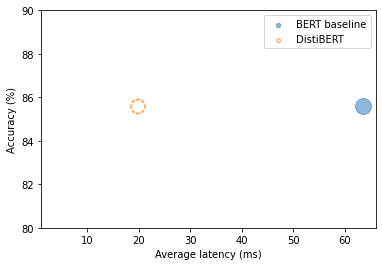

In [31]:
def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    
    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt['time_avg_ms'], df_opt['accuracy'] * 100,
                        alpha=0.5, s=df_opt['size_mb'], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt['time_avg_ms'], df_opt['accuracy'] * 100,
                        s=df_opt['size_mb'], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])
    
    plt.ylim(80, 90)                         
    
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics['BERT baseline']['time_avg_ms'] + 3)
    plt.xlim(1, xlim)
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Average latency (ms)')
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

# p226, Finding Good Hyperparameters with Optuna

In [32]:
def objective(trial):
    x = trial.suggest_float('x', -2, 2)
    y = trial.suggest_float('y', -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

study.best_params

{'x': 1.0391909464564157, 'y': 1.0787298121354585}

In [33]:
def hp_space(trial):
    return {
        'num_train_epochs': trial.suggest_int('num_train_epochs', 5, 10),
        'alpha': trial.suggest_float('alpha', 0, 1),
        'temperature': trial.suggest_int('temperature', 2, 20),
    }

In [34]:
best_run = getv('best_run')

if not best_run:
    best_run = distilbert_trainer.hyperparameter_search(
        n_trials=20, direction='maximize', hp_space=hp_space)
    putv(best_run, 'best_run')
    
print(best_run)

BestRun(run_id='8', objective=0.9290322580645162, hyperparameters={'num_train_epochs': 10, 'alpha': 0.38095769735625606, 'temperature': 2})


In [35]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)
    
# Define a new repository to store our distilled model
distilled_ckpt = 'distillbert-base-uncased-distilled-clinc'
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
        teacher_model=teacher_model, args=student_training_args,
        train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
        compute_metrics=compute_metrics, tokenizer=student_tokenizer)

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/olpa/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Bert

In [36]:
if TRAIN_DISTIL:
    distil_trainer.train()
    distil_trainer.push_to_hub()

In [37]:
pipe = pipeline('text-classification', model=distilled_ckpt)
optim_type = 'Distillation'
pb = PerformanceBenchmark(pipe, clinc['test'], optim_type=optim_type)

stu_disti_metrics = getv('stu_disti_metrics')
if not stu_disti_metrics:
    stu_disti_metrics = pb.run_benchmark()
    putv(stu_disti_metrics, 'stu_disti_metrics')

perf_metrics.update(stu_disti_metrics)
pb.print_performance_metrics(stu_disti_metrics)

loading configuration file distillbert-base-uncased-distilled-clinc/config.json
Model config DistilBertConfig {
  "_name_or_path": "distillbert-base-uncased-distilled-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meeting",
    "19": "meeting_schedule",
    "20": "freeze_account",
    "21": "what_song",
    "22": "meaning_of_life",
    "23": "restaurant_reservation",
  

loading configuration file distillbert-base-uncased-distilled-clinc/config.json
Model config DistilBertConfig {
  "_name_or_path": "distillbert-base-uncased-distilled-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meeting",
    "19": "meeting_schedule",
    "20": "freeze_account",
    "21": "what_song",
    "22": "meaning_of_life",
    "23": "restaurant_reservation",
  

loading weights file distillbert-base-uncased-distilled-clinc/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at distillbert-base-uncased-distilled-clinc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
Didn't find file distillbert-base-uncased-distilled-clinc/added_tokens.json. We won't load it.
loading file distillbert-base-uncased-distilled-clinc/vocab.txt
loading file distillbert-base-uncased-distilled-clinc/tokenizer.json
loading file None
loading file distillbert-base-uncased-distilled-clinc/special_tokens_map.json
loading file distillbert-base-uncased-distilled-clinc/tokenizer_config.json


Accuracy on test set - 0.875
Model size (MB) - 255.89
Average latency (ms) - 17.42 +/- 2.08


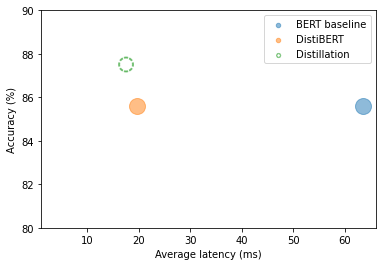

In [38]:
plot_metrics(perf_metrics, optim_type)

# p230, Making Models Faster with Quantization

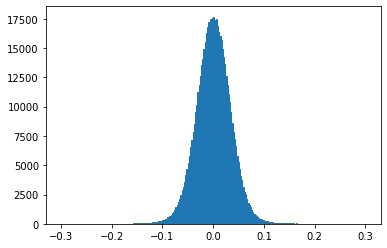

In [39]:
state_dict = pipe.model.state_dict()
weights = state_dict['distilbert.transformer.layer.0.attention.out_lin.weight']
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3, 0.3), edgecolor='C0')
plt.show()

In [40]:
fl = weights.flatten().numpy()
c1 = len([x for x in fl if x < -0.2])
c2 = len([x for x in fl if x >= -0.2 and x < 0.2])
c3 = len([x for x in fl if x >= 0.2])
c1, c2, c3

(157, 589517, 150)

In [41]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [42]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   1],
        [ -9,  -5,   5,  ...,   0,   6,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], dtype=torch.int8)

In [43]:
dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   1],
        [ -9,  -5,   5,  ...,   0,   6,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], dtype=torch.int8)

In [44]:
%%timeit
weights @ weights

3.07 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
q_fn = QFunctional()

In [46]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

88.1 µs ± 8.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [47]:
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

3.999755879241598

In [48]:
model_ckpt = 'distillbert-base-uncased-distilled-clinc'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt).to('cpu'))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

Didn't find file distillbert-base-uncased-distilled-clinc/added_tokens.json. We won't load it.
loading file distillbert-base-uncased-distilled-clinc/vocab.txt
loading file distillbert-base-uncased-distilled-clinc/tokenizer.json
loading file None
loading file distillbert-base-uncased-distilled-clinc/special_tokens_map.json
loading file distillbert-base-uncased-distilled-clinc/tokenizer_config.json
loading configuration file distillbert-base-uncased-distilled-clinc/config.json
Model config DistilBertConfig {
  "_name_or_path": "distillbert-base-uncased-distilled-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "a

loading weights file distillbert-base-uncased-distilled-clinc/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at distillbert-base-uncased-distilled-clinc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


In [49]:
pipe = pipeline('text-classification', model=model_quantized, tokenizer=tokenizer)
optim_type = 'Distillation + quantization'
pb = PerformanceBenchmark(pipe, clinc['test'], optim_type=optim_type)

quant_metrics = getv('quant_metrics')
if not quant_metrics:
    quant_metrics = pb.run_benchmark()
    putv(quant_metrics, 'quant_metrics')

perf_metrics.update(quant_metrics)
pb.print_performance_metrics(quant_metrics)

Accuracy on test set - 0.877
Model size (MB) - 132.40
Average latency (ms) - 9.11 +/- 1.60


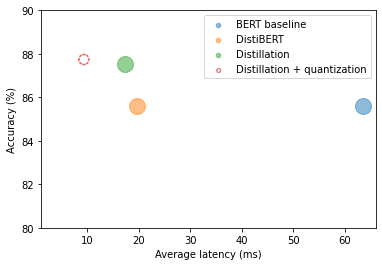

In [50]:
plot_metrics(perf_metrics, optim_type)

# p237, Optimizing Inference with ONNX and the ONNX Runtime

In [51]:
os.environ['OMP_NUM_THREADS'] = f'{psutil.cpu_count()}'
os.environ['OMP_WAIT_POLICY'] = 'ACTIVE'

In [53]:
model_ckpt = 'distillbert-base-uncased-distilled-clinc'
onnx_model_path = Path('onnx/model.onnx')

if BUILD_ONNX:
    transformers.convert_graph_to_onnx.convert(framework='pt', model=model_ckpt,
            tokenizer=tokenizer, output=onnx_model_path, opset=12,
            pipeline_name='text-classification')

loading configuration file distillbert-base-uncased-distilled-clinc/config.json
Model config DistilBertConfig {
  "_name_or_path": "distillbert-base-uncased-distilled-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meeting",
    "19": "meeting_schedule",
    "20": "freeze_account",
    "21": "what_song",
    "22": "meaning_of_life",
    "23": "restaurant_reservation",
  

loading configuration file distillbert-base-uncased-distilled-clinc/config.json
Model config DistilBertConfig {
  "_name_or_path": "distillbert-base-uncased-distilled-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meeting",
    "19": "meeting_schedule",
    "20": "freeze_account",
    "21": "what_song",
    "22": "meaning_of_life",
    "23": "restaurant_reservation",
  

loading weights file distillbert-base-uncased-distilled-clinc/pytorch_model.bin


ONNX opset version set to: 12
Loading pipeline (model: distillbert-base-uncased-distilled-clinc, tokenizer: PreTrainedTokenizerFast(name_or_path='distillbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))


All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at distillbert-base-uncased-distilled-clinc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
/home/olpa/.local/lib/python3.8/site-packages/transformers/models/distilbert/modeling_distilbert.py:214: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  scores = scores.masked_fill(mask, torch.tensor(-float("inf")))  # (bs, n_heads, q_length, k_length)


Using framework PyTorch: 1.11.0+cu102
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


In [54]:
def create_model_for_provider(model_path, provider='CPUExecutionProvider'):
    options = onnxruntime.SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
    session = onnxruntime.InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

onnx_model = create_model_for_provider(onnx_model_path)

In [61]:
inputs = clinc_enc['test'][:1]
del inputs['labels']

logits_onnx = onnx_model.run(None, inputs)[0]
print(f'shape: {logits_onnx.shape}')
print(f'inference from onnx: {np.argmax(logits_onnx)}')
print(f'ground truth: {clinc_enc["test"][0]["labels"]}')

shape: (1, 151)
inference from onnx: 61
ground truth: 61


In [83]:
class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors='pt')
        inputs_onnx = {
            k: v.cpu().detach().numpy()
            for k, v in model_inputs.items()
        }
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{ 'label': intents.int2str(pred_idx), 'score': probs[pred_idx]}]

In [85]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.8236891}]

In [86]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, model_path, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
    
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        return {'size_mb': size_mb}

In [88]:
optim_type = 'Distillation + ORT'
pb = OnnxPerformanceBenchmark('onnx/model.onnx', pipe, clinc['test'], optim_type=optim_type)

ort_metrics = getv('ort_metrics')
if not ort_metrics:
    ort_metrics = pb.run_benchmark()
    putv(ort_metrics, 'ort_metrics')

perf_metrics.update(ort_metrics)
pb.print_performance_metrics(ort_metrics)

Accuracy on test set - 0.875
Model size (MB) - 255.90
Average latency (ms) - 17.17 +/- 0.84


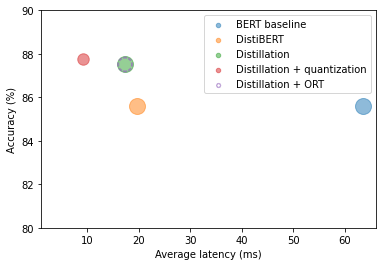

In [89]:
plot_metrics(perf_metrics, optim_type)

In [92]:
model_input = 'onnx/model.onnx'
model_output = 'onnx/model.quant.onnx'
if BUILD_ONNX:
    onnxruntime.quantization.quantize_dynamic(model_input, model_output,
            weight_type=onnxruntime.quantization.QuantType.QInt8)

In [93]:
onnx_quant_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quant_model, tokenizer)

optim_type = 'Distillation + ORT (quant)'
pb = OnnxPerformanceBenchmark(model_output, pipe, clinc['test'], optim_type=optim_type)

ort_q_metrics = getv('ort_q_metrics')
if not ort_q_metrics:
    ort_q_metrics = pb.run_benchmark()
    putv(ort_q_metrics, 'ort_q_metrics')

perf_metrics.update(ort_q_metrics)
pb.print_performance_metrics(ort_q_metrics)

Accuracy on test set - 0.882
Model size (MB) - 64.22
Average latency (ms) - 9.92 +/- 0.77


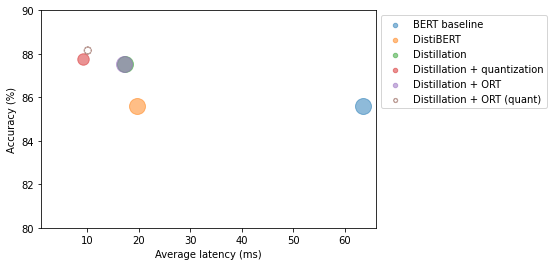

In [94]:
plot_metrics(perf_metrics, optim_type)

In [95]:
perf_metrics

{'BERT baseline': {'size_mb': 255.887375831604,
  'time_avg_ms': 63.491818769907695,
  'time_std_ms': 47.905953815786276,
  'accuracy': 0.856},
 'DistiBERT': {'size_mb': 255.887375831604,
  'time_avg_ms': 19.67837138017785,
  'time_std_ms': 37.39311006277697,
  'accuracy': 0.856},
 'Distillation': {'size_mb': 255.887375831604,
  'time_avg_ms': 17.41598898996017,
  'time_std_ms': 2.084269763532518,
  'accuracy': 0.8754545454545455},
 'Distillation + quantization': {'size_mb': 132.3969964981079,
  'time_avg_ms': 9.107921840004565,
  'time_std_ms': 1.602345947189188,
  'accuracy': 0.8774545454545455},
 'Distillation + ORT': {'size_mb': 255.89965057373047,
  'time_avg_ms': 17.174492340009238,
  'time_std_ms': 0.8368885615612697,
  'accuracy': 0.8754545454545455},
 'Distillation + ORT (quant)': {'size_mb': 64.22085094451904,
  'time_avg_ms': 9.916085309960181,
  'time_std_ms': 0.7713042666714884,
  'accuracy': 0.8818181818181818}}